# test notebook for stella ZAMS calc code

In [1]:
# imports
import numpy as np

import ray
from ray.util.multiprocessing import Pool

import pandas as pd
from scipy import optimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interpn

# from jax import grad, jit
# from jax import jacfwd, jacrev
# from jax.numpy import linalg

# from jax.config import config
# config.update("jax_enable_x64", True)

# constants
import constants as c
from scipy.constants import N_A

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_context("talk")
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

In [2]:
import interpolate
import energy
import density

Read Sections 18.0, 18.1, and 18.2 of Numerical Recipes, as it will be necessary
to implement the method of shooting to a fitting point (their shootf function) to
solve the boundary-value problem posed by the four coupled ordinary differential
equations of stellar structure and evolution. You will also need a program similar
to the newt function described in Section 9.7 of Numerical Recipes or in the
SciPy documentation to repeatedly call a shootf-like function, calculate updated
boundary values, and ultimately obtain a converged solution. Faster convergence
can usually be obtained by using fractions of the updates suggested by a newt-
like function. Ordinary differential equation (ODE) solvers like those described
in Sections 17.0, 17.1, and 17.2 of Numerical Recipes or the SciPy documentation
are also critical.

In [3]:
def load_inner(Tc, Pc, factor=1e-12):
    """
    Returns reasonable guess for an integration
    starting point exterior to the absolute center
    """
    rho_c = density.density(Pc,Tc, X=0.7)

    m = factor*c.Ms # set start just outside center
    epsilon = energy.energy_gen(rho_c,Tc)
    l = epsilon*m # determine energy generation from pp and CNO
    
    r = (3/(4*np.pi*rho_c))**(1/3) * m**(1/3) # radius start
    
    P = Pc - (3*c.G/(8*np.pi))*((4*np.pi*rho_c/3)**(4/3))*(m**(2/3))
    
    del_rad = energy.del_rad(m, l, P, rho_c, Tc)
    if del_rad > energy.del_ad:
#         print('convective core')
        lnT = np.log(Tc) - (np.pi/6)**(1/3)*c.G*(energy.del_ad*rho_c**(4/3))/Pc*m**(2/3)
        T = np.exp(lnT)
    else:
#         print('radiative core')
        kappa_c = interpolate.interp_k(rho_c,Tc)
        T = (Tc**4 - (1/(2*c.a*c.c)*(3/(4*np.pi))**(2/3)*kappa_c*epsilon*rho_c**(4/3)*m**(2/3)))**(1/4)
    
    return np.array([l, P, r, T])

def load_outer(M_star, L_star, R_star, factor=0.9999):
    """
    Returns reasonable guess for an integration
    starting point interior to the photosphere.
    """
    
    mu = 4/(3+5*0.7)
    surface_g = c.G*M_star/(R_star**2)
    Teff = (L_star/(4*np.pi*c.sb*R_star**2))**(1/4)
    
    def min_rho(rho):
        opacity_pressure = (2/3) * surface_g / interpolate.interp_k(rho,Teff)
        gas_rad_pressure = (1/3)*c.a*Teff**4 + rho * N_A*c.k*Teff/mu
        diff = 1 - opacity_pressure/gas_rad_pressure
        return np.abs(diff**2)
    
    rho_sol = optimize.minimize(min_rho, 1e-8, args=(), method='Nelder-Mead', bounds=[(1e-13,1e-5)])
    if rho_sol.success:
        rho = rho_sol.x[0]
    else:
        print('there\'s no rho for this Teff, log(g)')
        rho = np.nan
    kappa = interpolate.interp_k(rho,Teff)
    P = 2*surface_g/(3*kappa)
    
    return np.array([L_star, P, R_star, Teff])


def odeEZ(m,v):
    l, P, r, T = v
    rho = density.density(P,T, X=0.7) # density
    del_radiative = energy.del_rad(m, l, P, rho, T)
    del_actual = np.minimum(del_radiative, energy.del_ad)
    
    dldm = energy.energy_gen(rho,T, psi=1) #change in Luminosity with enclosed mass
    dPdm = -c.G*m/(4*np.pi*r**4) # change in pressure with enclosed mass
    drdm = 1/(4*np.pi*r**2 * rho) # mass conservation eq.
    dTdm = ((-c.G*m*T)/(4*np.pi*P*r**4))*del_actual # change in temperature with enclosed mass
    
    return np.array([dldm, dPdm, drdm, dTdm])
    

In [4]:
def shooter(vec, M_star=1.0*c.Ms,  n=int(1e5), in_factor=1e-12, out_factor=0.9999, M_fit=0.5):
    
    L_star, Pc, R_star, Tc = vec
    
#     print(vec)
    
    inn = load_inner(Tc, Pc, factor=in_factor)
    outt = load_outer(M_star, L_star, R_star, factor=out_factor)
    
#     print(inn)
#     print(outt)
    
    # protect against low Teff solutions which crash the root finder
    if np.isnan(np.sum(inn)) or np.isnan(np.sum(outt)):
        print('caught a nan in the guess')
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        return np.array([dL, dP, dR, dT])


    exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
    entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

    ray.init(num_cpus=4)
    pool = Pool()
    
    sol_i = pool.apply(solve_ivp, [odeEZ, (exiting[0], exiting[-1]), inn, 'RK45', exiting])
#     sol_i = solve_ivp(odeEZ, (exiting[0], exiting[-1]), inn, method='RK45', t_eval=exiting) 
    if sol_i.status == 0:
        print('solved inner')
    else:
        print('failed to solve interior', sol_i.message)
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        ray.shutdown()
        return np.array([dL, dP, dR, dT])
    sol_s = pool.apply(solve_ivp, [odeEZ, (entering[0], entering[-1]), outt, 'RK45', entering])
    if sol_s.status == 0:
        print('solved exterior')
    else:
        print('failed to solve exterior', sol_s.message)
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        ray.shutdown()
        return np.array([dL, dP, dR, dT])
    
    ray.shutdown()
    
    exiting_sol = sol_i.y
    entering_sol = sol_s.y
    
#     print(exiting_sol)
#     print(entering_sol)

    dL = (exiting_sol[0,-1] - entering_sol[0,-1])/L_star
    dP = (exiting_sol[1,-1] - entering_sol[1,-1])/Pc
    dR = (exiting_sol[2,-1] - entering_sol[2,-1])/R_star
    dT = (exiting_sol[3,-1] - entering_sol[3,-1])/Tc
    
    res = np.array([dL, dP, dR, dT])
    
    print(res)
    print(np.sum(res**2))

    return res

In [5]:
def solver(vec_final, M_star=1.0*c.Ms,  n=int(1e5), in_factor=1e-12, out_factor=0.9999, M_fit=0.5):
    
    L_star, Pc, R_star, Tc = vec_final
    
    inn = load_inner(Tc, Pc, factor=in_factor)
    outt = load_outer(M_star, L_star, R_star, factor=out_factor)

    exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
    entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

    ray.init(num_cpus=2)
    pool = Pool()
    
    sol_i = pool.apply(solve_ivp, [odeEZ, (exiting[0], exiting[-1]), inn, 'RK45', exiting])
    sol_s = pool.apply(solve_ivp, [odeEZ, (entering[0], entering[-1]), outt, 'RK45', entering])
    
    ray.shutdown()
    
    exiting_sol = sol_i.y
    entering_sol = sol_s.y
    
    # combine mass arrays
    mass = np.concatenate([exiting, np.flipud(entering)], axis=0)
    
    # add mass to final array
    solution = np.zeros((7, mass.shape[0]))
    solution[0] = mass
    
    # combine solution arrays
    sols = np.concatenate([exiting_sol, np.fliplr(entering_sol)], axis=1)
    solution[1:5] = sols
    
    # add density as 6th column
    rho = density.density(solution[2],solution[4], X=0.7)
    solution[5] = rho
    
    # add del_rad as 7th column
#     del_rad = (3/(16*np.pi*c.a*c.c))*(solution[1]*interpolate.interp_k(rho, solution[3])/solution[3]**4)*(solution[0]/(c.G*mass))
    del_rad = energy.del_rad(mass, solution[1], solution[2], rho, solution[4])
    solution[6] = del_rad
    
    return solution

In [6]:
# surface
M_star = 1.3*c.Ms
L_star = (M_star/c.Ms)**(3.5)*c.Ls # eq. 1.88 HKT
R_star = (M_star/c.Ms)**(0.75)*c.Rs # eq. 1.87 HKT
# surface_guess = load_outer(M_star, L_star, R_star, factor=0.9999)
# core
# Pc = 2.65e17, sun
P_factor = 1e1 # guess to inflate constant density sphere pressure
Pc = (3/(8*np.pi))*(c.G*(M_star)**2)/(R_star)**4 * P_factor # constant density sphere, lower limit!
# Tc = 15e6, sun
Tc = (1/2)*((4/(3+5*0.7))/(N_A*c.k))*(c.G*M_star)/(R_star) # constant density sphere

vec = np.array([L_star, Pc, R_star, Tc])
args = (M_star, int(1e5), 1e-12, 0.9999, 0.75)

from scipy.optimize import least_squares, root

bounds = ([L_star*1e-1,Pc,R_star*1e-1,Tc], [L_star*1e2, Pc*1e4, R_star*1e1, Tc*1e3])
# bounds = [(L_star*1e-2,L_star*1e2),(Pc,Pc*1e2),(R_star*1e-2,R_star*1e2),(Tc,Tc*1e2)]

# x_scale = np.array([1e31, 1e14, 1e9, 1e6])

# todo, set x_scale for each variable to enable better tolerance estimate
final = least_squares(shooter, vec, args=args, bounds=bounds, 
                      method='dogbox', loss='arctan', 
                      gtol=1e-15, 
                      xtol=None, 
                      ftol=None, 
                      x_scale='jac', # x_scale
                     )

# final = root(shooter, vec, args=args)


2023-04-14 16:48:09,410	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99082621 -0.81118294  0.37588715  0.05523551]
1.7840964446641319


2023-04-14 16:48:28,033	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99082621 -0.81118294  0.37588715  0.0552355 ]
1.7840964513561994


2023-04-14 16:48:46,884	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99082621 -0.81118292  0.37588715  0.05523551]
1.7840964232219805


2023-04-14 16:49:04,156	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99082621 -0.81118291  0.37588714  0.05523552]
1.7840963919130817


2023-04-14 16:49:20,534	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99082621 -0.81118293  0.37588715  0.05523552]
1.784096432439355
there's no rho for this Teff, log(g)
caught a nan in the guess


2023-04-14 16:49:41,561	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99115223 -0.57136047  0.32355324  0.10951848]
1.4255165174554378


2023-04-14 16:49:58,739	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99115223 -0.57136048  0.32355324  0.10951848]
1.4255165335270354


2023-04-14 16:50:16,398	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99115223 -0.57136046  0.32355323  0.10951848]
1.4255165062637551


2023-04-14 16:50:32,235	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99115223 -0.57136015  0.32355319  0.10951856]
1.4255161441088462


2023-04-14 16:50:49,875	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.99115223 -0.57136046  0.32355323  0.1095185 ]
1.4255165100049447


2023-04-14 16:51:06,678	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.98204836 -0.50760447  0.29673096  0.23045804]
1.363241444602839


2023-04-14 16:51:23,835	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.98204836 -0.5076045   0.29673097  0.23045803]
1.3632414795023522


2023-04-14 16:51:40,833	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.98204836 -0.50760446  0.29673096  0.23045804]
1.3632414345267658


2023-04-14 16:51:57,809	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.98204836 -0.50760416  0.29673092  0.2304581 ]
1.3632411405950309


2023-04-14 16:52:14,679	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.98204836 -0.50760446  0.29673096  0.23045805]
1.363241439028696


2023-04-14 16:52:35,703	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.96289514 -0.42696684  0.28246142  0.3439829 ]
1.3075764324904076


2023-04-14 16:52:52,754	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.96289515 -0.42696686  0.28246142  0.3439829 ]
1.3075764437518775


2023-04-14 16:53:09,648	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.96289514 -0.42696683  0.28246141  0.3439829 ]
1.3075764234300131


2023-04-14 16:53:26,602	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.96289514 -0.4269668   0.28246141  0.34398291]
1.3075763975208818


2023-04-14 16:53:44,055	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.96289514 -0.42696683  0.28246141  0.34398291]
1.3075764273927564


2023-04-14 16:54:01,229	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.92659334 -0.34770707  0.27805865  0.42851047]
1.2404132543030015


2023-04-14 16:54:19,085	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.92659334 -0.34770708  0.27805865  0.42851047]
1.2404132598454751


2023-04-14 16:54:36,047	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.92659334 -0.34770706  0.27805865  0.42851047]
1.2404132458090256


2023-04-14 16:54:53,054	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.92659334 -0.34770704  0.27805865  0.42851047]
1.2404132324201045


2023-04-14 16:55:10,089	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.92659333 -0.34770706  0.27805865  0.42851048]
1.2404132477096623


2023-04-14 16:55:26,989	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.82259995 -0.25703085  0.2840516   0.52065631]
1.0945038347969944


2023-04-14 16:55:44,103	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.82259995 -0.25703086  0.2840516   0.5206563 ]
1.0945038415297477


2023-04-14 16:56:01,197	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.82259995 -0.25703084  0.2840516   0.52065631]
1.0945038255584008


2023-04-14 16:56:18,508	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.82259995 -0.25703082  0.2840516   0.52065631]
1.094503817658342


2023-04-14 16:56:34,164	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.82259994 -0.25703084  0.2840516   0.52065631]
1.0945038200097266


2023-04-14 16:56:50,297	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 5.45748856e+01 -3.79287184e-03  3.40476377e-01  7.04934895e-01]
2979.0310063386964


2023-04-14 16:57:07,068	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.58167044 -0.17628642  0.29430701  0.58795638]
0.8017267257642557


2023-04-14 16:57:23,204	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.58167044 -0.17628643  0.29430701  0.58795638]
0.8017267343664805


2023-04-14 16:57:39,922	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.58167043 -0.17628641  0.29430701  0.58795638]
0.801726714966952


2023-04-14 16:57:56,019	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.58167044 -0.17628638  0.294307    0.58795639]
0.8017267131319238


2023-04-14 16:58:12,946	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.58167039 -0.17628641  0.29430701  0.58795639]
0.8017266720212106


2023-04-14 16:58:30,612	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 5.24453045 -0.06429812  0.3064635   0.65438298]
28.031370898324763


2023-04-14 16:58:47,113	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.26244088 -0.1441422   0.29681732  0.60789568]
0.5472898606036667


2023-04-14 16:59:04,021	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.26244089 -0.14414221  0.29681732  0.60789567]
0.5472898672929338


2023-04-14 16:59:20,775	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.26244087 -0.14414219  0.29681731  0.60789568]
0.5472898515876884


2023-04-14 16:59:37,437	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.26244088 -0.14414216  0.29681731  0.60789568]
0.5472898500315355


2023-04-14 16:59:53,409	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.26244076 -0.14414219  0.29681732  0.60789568]
0.5472898031581865


2023-04-14 17:00:10,850	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0360374  -0.12476477  0.29367957  0.61235797]
0.47809491712097346


2023-04-14 17:00:27,928	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.03603739 -0.12476479  0.29367957  0.61235796]
0.47809491494397505


2023-04-14 17:00:44,876	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.03603742 -0.12476476  0.29367957  0.61235797]
0.47809491461453435


2023-04-14 17:01:01,950	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0360374  -0.12476472  0.29367956  0.61235798]
0.47809491169020263


2023-04-14 17:01:19,045	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.03603759 -0.12476476  0.29367957  0.61235798]
0.47809493649388607


2023-04-14 17:01:35,030	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03214825 -0.09347808  0.27053151  0.59328716]
0.4349486149319389


2023-04-14 17:01:51,668	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03214826 -0.09347809  0.27053151  0.59328716]
0.43494861560166004


2023-04-14 17:02:09,415	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03214823 -0.09347808  0.27053151  0.59328716]
0.43494861155012654


2023-04-14 17:02:26,415	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03214825 -0.09347806  0.2705315   0.59328716]
0.43494861003255963


2023-04-14 17:02:43,350	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03214809 -0.09347808  0.27053151  0.59328717]
0.43494861103877197


2023-04-14 17:02:59,986	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.02681759 -0.10068226  0.26328841  0.57778252]
0.4140095288305595


2023-04-14 17:03:15,835	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.02681761 -0.10068227  0.26328841  0.57778252]
0.41400952950423986


2023-04-14 17:03:33,259	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.02681758 -0.10068225  0.26328841  0.57778252]
0.4140095256150389


2023-04-14 17:03:49,103	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.02681759 -0.10068223  0.2632884   0.57778253]
0.4140095236964823


2023-04-14 17:04:06,683	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.02681744 -0.10068225  0.26328841  0.57778253]
0.414009526866184


2023-04-14 17:04:23,460	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06293404 -0.11494863  0.24564192  0.53742593]
0.366340458455973


2023-04-14 17:04:40,609	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06293405 -0.11494863  0.24564192  0.53742593]
0.3663404598120038


2023-04-14 17:04:57,685	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06293403 -0.11494862  0.24564191  0.53742593]
0.36634045463211834


2023-04-14 17:05:14,991	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06293404 -0.1149486   0.24564191  0.53742593]
0.3663404540618736


2023-04-14 17:05:30,995	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06293392 -0.11494862  0.24564192  0.53742593]
0.3663404492380282


2023-04-14 17:05:48,290	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06492841 -0.14774636  0.23647291  0.48848216]
0.3205789428403589


2023-04-14 17:06:04,483	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06492842 -0.14774637  0.23647292  0.48848215]
0.32057894440020007


2023-04-14 17:06:21,411	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.0649284  -0.14774636  0.23647291  0.48848216]
0.32057893890478995


2023-04-14 17:06:38,251	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06492841 -0.14774634  0.23647291  0.48848216]
0.32057893771025964


2023-04-14 17:06:55,810	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.06492832 -0.14774636  0.23647291  0.48848216]
0.32057893532367665


2023-04-14 17:07:12,095	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.05770257 -0.15876299  0.22632864  0.44300779]
0.2760158285442241


2023-04-14 17:07:29,531	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.05770258 -0.15876299  0.22632864  0.44300779]
0.2760158298294088


2023-04-14 17:07:46,997	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.05770256 -0.15876298  0.22632864  0.44300779]
0.2760158249160377


2023-04-14 17:08:04,418	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.05770257 -0.15876297  0.22632864  0.44300779]
0.276015823725585


2023-04-14 17:08:21,627	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.05770249 -0.15876298  0.22632864  0.4430078 ]
0.27601582357235704


2023-04-14 17:08:38,839	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.11553138 -0.17219841  0.21685421  0.35403213]
0.21536429144894653


2023-04-14 17:08:56,534	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.11553139 -0.17219842  0.21685421  0.35403213]
0.21536429442519084


2023-04-14 17:09:18,342	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.11553138 -0.17219841  0.21685421  0.35403213]
0.215364287547105


2023-04-14 17:09:35,775	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.11553138 -0.1721984   0.21685421  0.35403213]
0.21536428700256466


2023-04-14 17:09:52,810	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.11553131 -0.17219841  0.21685421  0.35403214]
0.21536427984059126


2023-04-14 17:10:11,851	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.10221552 -0.15144797  0.20262391  0.28373588]
0.15494699872530032


2023-04-14 17:10:34,899	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.10221554 -0.15144798  0.20262391  0.28373588]
0.15494700112045184


2023-04-14 17:10:55,533	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.10221553 -0.15144797  0.20262391  0.28373587]
0.1549469959927244


2023-04-14 17:11:13,423	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.10221552 -0.15144796  0.2026239   0.28373588]
0.1549469957018932


2023-04-14 17:11:32,339	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.10221545 -0.15144797  0.2026239   0.28373589]
0.15494698749889896


2023-04-14 17:11:51,273	INFO worker.py:1553 -- Started a local Ray instance.
(PoolActor pid=90596) /Users/wbalmer/stellarinteriors/stella/interpolate.py:24: RuntimeWarning: invalid value encountered in log10
(PoolActor pid=90596)   logR_i = np.log10(rho_i/(T_i/1e6)**3)
(PoolActor pid=90596) /Users/wbalmer/stellarinteriors/stella/energy.py:27: RuntimeWarning: invalid value encountered in scalar power
(PoolActor pid=90596)   term2 = (zeta*rho/(T7**3))**(1/2)
(PoolActor pid=90596) /Users/wbalmer/stellarinteriors/stella/interpolate.py:26: RuntimeWarning: invalid value encountered in log10
(PoolActor pid=90596)   logT_i = np.log10(T_i)
(PoolActor pid=90596) /Users/wbalmer/stellarinteriors/stella/energy.py:50: RuntimeWarning: invalid value encountered in scalar power
(PoolActor pid=90596)   return 2.57e4 * psi * f_weak * g_pp * rho * X1**2 * T9**(-2/3) * np.exp(-3.381/(T9**(1/3)))
(PoolActor pid=90596) /Users/wbalmer/stellarinteriors/stella/energy.py:57: RuntimeWarning: invalid value encount

failed to solve interior Required step size is less than spacing between numbers.


2023-04-14 17:12:12,119	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.04043978 -0.12959206  0.18857749  0.25954059]
0.12135226435922929


2023-04-14 17:12:30,053	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.04043979 -0.12959206  0.18857749  0.25954059]
0.12135226515324637


2023-04-14 17:12:47,377	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.04043978 -0.12959206  0.18857749  0.25954058]
0.12135226126865548


2023-04-14 17:13:04,556	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.04043978 -0.12959205  0.18857748  0.25954059]
0.12135226210854559


2023-04-14 17:13:25,656	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.04043969 -0.12959205  0.18857749  0.2595406 ]
0.12135226178733005


2023-04-14 17:13:42,931	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13611255 -0.11127918  0.16890747  0.13102266]
0.07660635583114156


2023-04-14 17:13:59,171	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13611257 -0.11127919  0.16890747  0.13102266]
0.07660635948296635


2023-04-14 17:14:18,051	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13611259 -0.11127919  0.16890748  0.13102263]
0.07660635984028007


2023-04-14 17:14:38,983	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13611255 -0.11127918  0.16890747  0.13102266]
0.07660635339112279


2023-04-14 17:14:57,428	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.13611245 -0.11127917  0.16890747  0.13102269]
0.07660633176601254


2023-04-14 17:15:14,304	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.2925406  -0.05557356  0.0501945  -0.27378189]
0.16614443546111257


2023-04-14 17:15:32,904	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03614031 -0.08165019  0.1362506   0.09857913]
0.03625494743885253


2023-04-14 17:15:51,760	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03614033 -0.08165019  0.1362506   0.09857913]
0.03625494849841499


2023-04-14 17:16:10,325	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03614036 -0.0816502   0.13625061  0.09857909]
0.03625494344541712


2023-04-14 17:16:28,933	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.03614031 -0.08165018  0.1362506   0.09857913]
0.03625494602138614


2023-04-14 17:16:47,787	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.0361402  -0.08165018  0.1362506   0.09857917]
0.036254943828444


2023-04-14 17:17:06,867	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.01084594 -0.05330501  0.07298927 -0.15370849]
0.03191279299335129


2023-04-14 17:17:26,034	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.01084596 -0.05330501  0.07298927 -0.15370849]
0.0319127940695452


2023-04-14 17:17:43,330	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.010846   -0.05330504  0.07298923 -0.15370897]
0.03191293852676358


2023-04-14 17:18:05,737	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.01084594 -0.05330501  0.07298926 -0.15370849]
0.03191279071602171


2023-04-14 17:18:24,282	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-0.01084581 -0.05330499  0.07298929 -0.15370812]
0.03191267672764129


2023-04-14 17:18:42,281	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.03225332 -0.03881041  0.0694756  -0.00552262]
0.007403882016553755


2023-04-14 17:19:00,316	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0322533  -0.03881041  0.0694756  -0.00552262]
0.0074038812275335165


2023-04-14 17:19:18,495	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.03225327 -0.03881042  0.06947559 -0.00552285]
0.007403881127277485


2023-04-14 17:19:37,506	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.03225332 -0.03881041  0.06947559 -0.00552261]
0.007403881086309079


2023-04-14 17:19:55,963	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.03225345 -0.03881039  0.0694756  -0.00552245]
0.007403887284635138


2023-04-14 17:20:15,072	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0179375  -0.02811574  0.05229521 -0.01757132]
0.004155789249855617


2023-04-14 17:20:33,612	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.01793748 -0.02811574  0.05229521 -0.01757132]
0.0041557889040227695


2023-04-14 17:20:53,057	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.01793744 -0.02811576  0.05229519 -0.01757169]
0.004155799438132686


2023-04-14 17:21:12,787	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.0179375  -0.02811574  0.05229521 -0.01757132]
0.004155788516026742


2023-04-14 17:21:30,631	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.01793763 -0.02811573  0.05229522 -0.01757105]
0.004155784012924988


2023-04-14 17:21:48,577	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00809798 -0.01132262  0.02444958 -0.00990144]
0.0008895994642025253


2023-04-14 17:22:05,982	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00809797 -0.01132262  0.02444958 -0.00990144]
0.0008895993046835694


2023-04-14 17:22:23,831	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00809793 -0.01132264  0.02444955 -0.00990195]
0.0008896080306279797


2023-04-14 17:22:41,787	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00809798 -0.01132262  0.02444957 -0.00990144]
0.0008895991768741201


2023-04-14 17:22:59,418	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00809811 -0.0113226   0.02444959 -0.00990107]
0.000889594251285438


2023-04-14 17:23:16,789	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00012298 -0.00062402  0.00264573 -0.00354162]
1.9947474241972496e-05


2023-04-14 17:23:37,097	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00012297 -0.00062402  0.00264573 -0.00354162]
1.994748365345491e-05


2023-04-14 17:23:56,949	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00012293 -0.00062404  0.0026457  -0.00354228]
1.9952067832551728e-05


2023-04-14 17:24:14,223	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00012298 -0.00062402  0.00264573 -0.00354162]
1.9947447063931936e-05


2023-04-14 17:24:31,583	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[ 0.00012311 -0.000624    0.00264575 -0.00354113]
1.9944069034475636e-05


2023-04-14 17:24:49,053	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-2.63660874e-05  1.17428564e-03 -9.68194749e-04  1.58746090e-03]
4.837075122755464e-06


2023-04-14 17:25:04,828	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-2.63809741e-05  1.17428528e-03 -9.68193831e-04  1.58745924e-03]
4.83706801172776e-06


2023-04-14 17:25:22,184	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-2.64219207e-05  1.17426313e-03 -9.68220924e-04  1.58680471e-03]
4.834992952949081e-06


2023-04-14 17:25:39,650	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-2.63661314e-05  1.17428712e-03 -9.68197860e-04  1.58746448e-03]
4.837095986331113e-06


2023-04-14 17:25:57,062	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-2.62362723e-05  1.17430605e-03 -9.68180459e-04  1.58794617e-03]
4.838629486935704e-06


2023-04-14 17:26:13,907	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08495249e-05  6.02037696e-04  2.13982678e-04  5.26160846e-05]
4.1112413854745065e-07


2023-04-14 17:26:30,775	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08644118e-05  6.02037371e-04  2.13983531e-04  5.26144783e-05]
4.1112426603466054e-07


2023-04-14 17:26:47,664	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.09053733e-05  6.02015167e-04  2.13956268e-04  5.19576517e-05]
4.110180712654352e-07


2023-04-14 17:27:04,935	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08495699e-05  6.02039116e-04  2.13979688e-04  5.26195666e-05]
4.1112493603482455e-07


2023-04-14 17:27:21,815	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.07197004e-05  6.02058121e-04  2.13997110e-04  5.31029940e-05]
4.1120358427782676e-07


2023-04-14 17:27:39,341	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08176335e-05  5.85317938e-04  2.44382597e-04 -2.88392799e-05]
4.032686676416023e-07


2023-04-14 17:27:56,699	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08325204e-05  5.85317615e-04  2.44383446e-04 -2.88408790e-05]
4.032691185423647e-07


2023-04-14 17:28:12,668	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08734851e-05  5.85295405e-04  2.44356166e-04 -2.94981823e-05]
4.0326902255561e-07


2023-04-14 17:28:29,117	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08176784e-05  5.85319347e-04  2.44379628e-04 -2.88358195e-05]
4.032686672361073e-07


2023-04-14 17:28:46,677	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.06878071e-05  5.85338366e-04  2.44397044e-04 -2.83520311e-05]
4.032689849832934e-07


2023-04-14 17:29:03,969	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08299179e-05  5.85364658e-04  2.44263255e-04 -2.88983057e-05]
4.0326872015297145e-07


2023-04-14 17:29:21,550	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08326326e-05  5.85327748e-04  2.44351423e-04 -2.88987978e-05]
4.0326867678456517e-07


2023-04-14 17:29:39,476	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08333112e-05  5.85318502e-04  2.44373496e-04 -2.88989354e-05]
4.032686636076028e-07


2023-04-14 17:29:55,796	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08481980e-05  5.85318173e-04  2.44374355e-04 -2.89005394e-05]
4.0326911344002594e-07


2023-04-14 17:30:13,307	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08891627e-05  5.85295969e-04  2.44347065e-04 -2.95578387e-05]
4.032690993663383e-07


2023-04-14 17:30:30,355	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.08333567e-05  5.85319993e-04  2.44370386e-04 -2.88954073e-05]
4.0326868616624724e-07


2023-04-14 17:30:47,753	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
[-1.07034847e-05  5.85338930e-04  2.44387943e-04 -2.84116860e-05]
4.0326891848980647e-07


In [7]:
if np.sum(final.active_mask**2) != 0:
    print('something ran up against a bound')

In [8]:
final

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.083e-05  5.853e-04  2.444e-04 -2.890e-05]
           x: [ 9.584e+33  1.956e+17  9.829e+10  1.670e+07]
        cost: 2.0163433180379467e-07
         jac: [[-1.042e-34 -1.916e-17 -3.109e-14  5.216e-07]
               [-2.306e-36 -7.730e-18  1.018e-12  8.208e-08]
               [ 6.016e-36 -9.067e-18 -2.123e-12  5.805e-08]
               [-1.123e-35 -2.260e-16  2.409e-12  1.958e-06]]
        grad: [ 1.574e-39 -4.666e-25  7.693e-18 -2.151e-17]
  optimality: 2.1514414272741857e-17
 active_mask: [0 0 0 0]
        nfev: 35
        njev: 28

In [9]:
solution = solver(final.x, M_star=args[0],  n=args[1], in_factor=args[2], out_factor=args[3], M_fit=args[4])

2023-04-14 17:31:04,812	INFO worker.py:1553 -- Started a local Ray instance.


In [10]:
# what is an appropriate P_factor to speed up convergence?
print('ratio between constant density Pc and converged solution',solution[2].max()/(Pc/P_factor))

ratio between constant density Pc and converged solution 189.40154971774467


In [11]:
print('ratio between constant density Tc and converged solution',solution[4].max()/Tc)

ratio between constant density Tc and converged solution 2.2166647730483184


(0.0, 1.1)

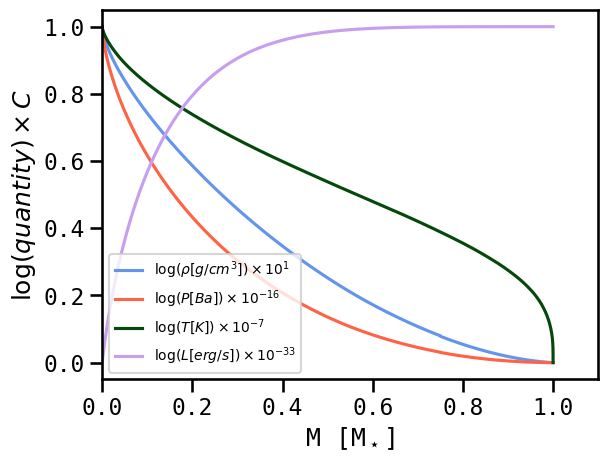

In [12]:
# a figure like 9.1 in HKT but in mass space, y-values near 1

plt.plot(solution[0]/M_star, solution[5]/solution[5].max(), color='cornflowerblue', label=r'$\log(\rho [g/cm^3])\times10^1$')
plt.plot(solution[0]/M_star, solution[2]/solution[2].max(), color='tomato', label=r'$\log(P [Ba])\times10^{-16}$')
plt.plot(solution[0]/M_star, solution[4]/solution[4].max(), color='xkcd:forest green', label=r'$\log(T [K])\times10^{-7}$')
plt.plot(solution[0]/M_star, solution[1]/solution[1].max(), color='xkcd:lavender', label=r'$\log(L [erg/s])\times10^{-33}$')

# plt.yscale('log')
plt.xlabel(r'M [M$_\star$]')
plt.ylabel(r'$\log(quantity)\times C$')
plt.legend(fontsize=10)
# plt.ylim(1e-3,1e3)
plt.xlim(0,1.1)


(0.0, 1.1)

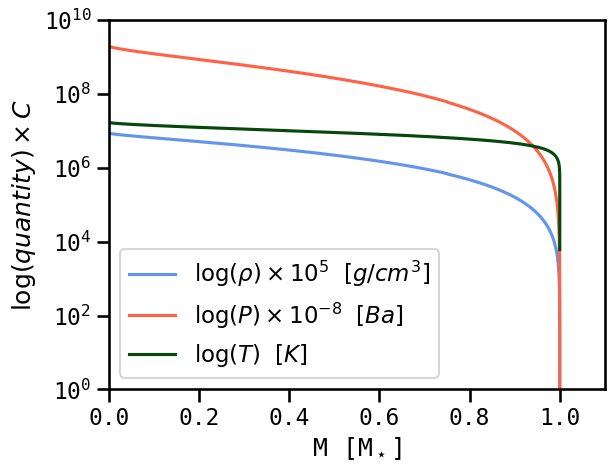

In [13]:
# reproduce figure 9.1 in HKT but in mass space

plt.plot(solution[0]/M_star, solution[5]*1e5, color='cornflowerblue', label=r'$\log(\rho)\times10^5$ $[g/cm^3]$')
plt.plot(solution[0]/M_star, solution[2]*1e-8, color='tomato', label=r'$\log(P)\times10^{-8}$ $[Ba]$')
plt.plot(solution[0]/M_star, solution[4], color='xkcd:forest green', label=r'$\log(T)$ $[K]$')

plt.yscale('log')
plt.xlabel(r'M [M$_\star$]')
plt.ylabel(r'$\log(quantity)\times C$')
plt.legend()
plt.ylim(1,1e10)
plt.xlim(0,1.1)

In [14]:
with open('converged_interior.npy', 'wb') as f:
    np.save(f, solution)